In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")

device = torch.device("cpu")

# Style transfer with Deep Neural Networks

## Introduction

Convolutional neural networks, a special type of neural network primerally used in computer vision, are compositional.

It means that the early layers in the network tends to learn simple features like edges, colour and texture, while deeper layers learn more complex shapes which are a composition of the previous, simple features.

What if we take two images, one with the content and the other one with the style, to output a third one with the content from the first image and the style from the second image?

![example](https://godatadriven.com/wp-content/images/how-to-style-transfer/style-transfer-example.jpg)

## How does it works? Maths!

+ A neural network is a function, like any mathematical function, it as an input and an output
+ In computer vision, it takes an image as an input, and most of the time, tries to classifies it by outputting the category it belongs to
+ However, we can also modify the inputs using a trained ANN with frozen weights
+ Given two images `content` and `style`
    - Extract features from two images using `Conv` layers of `VGG19` (other ANNs can also be used)
    - Mix the features according to predefined schema
    - Compute the gradients with respect to the `content` image and update it

## VGG19 Architecture

![architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

We use VGG19 pretrained on ImageNet to define the style and content extractor

In [3]:
class VGGFeatureExtractor(nn.Module):
    # Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch
    # modified with vgg19
    def __init__(self):
        super(VGGFeatureExtractor,self).__init__()
        # load VGG19 without classification layers
        self.features = torchvision.models.vgg19(weights='DEFAULT').features
        
        # making this model's parameters untrainable (freeze)
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self, x, layerIndices):
        outputs = list()  #outputs from the selected layers
        
        # for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) # apply the layer
            
            # if this layer is a desired layer, store its outputs
            if i in layerIndices:
                outputs.append(x)
                
                # check if we got all desired layers
                if i == layerIndices[-1]:
                    return outputs
                    
        return outputs

feature_extractor = VGGFeatureExtractor()
feature_extractor = feature_extractor.to(device)
feature_extractor

VGGFeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), str

In [4]:
# define the feature mixing schema

content_layers = [2, 7, 12, 25, 28]
style_layers   = [0, 5, 10, 30, 34]

# Weights we'll give to the different losses
style_weight, content_weight = 5, 1

# Let's make it work! 

Let's try to take a picture of Klagenfurt and add the style of picture on top of it.

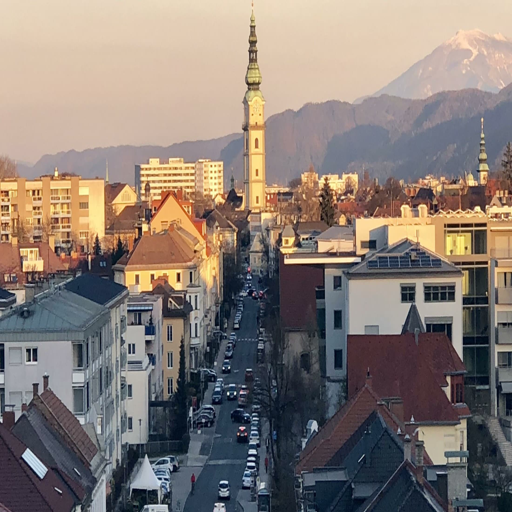

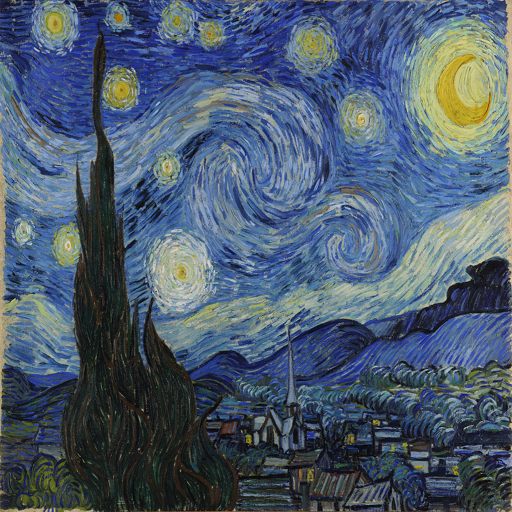

In [5]:
!curl -s --output cat.jpeg "https://imgl.krone.at/scaled/2093570/vddd60f/full.jpg"
content_image = Image.open('cat.jpeg').resize((512, 512))

!curl -s --output style.jpeg "https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/starry_night_google.jpg"
style_image = Image.open('style.jpeg').resize((512, 512))

display(content_image)
display(style_image)

In [6]:
# extract features from the content and style images
content_im_tensor = torch.tensor(np.array(content_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
target_content_features = feature_extractor(content_im_tensor, content_layers)

style_im_tensor = torch.tensor(np.array(style_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
target_style_features = feature_extractor(style_im_tensor, style_layers)

### Content loss

- The idea is to preserve the content of the image (i.e., the output of the content layers needs to stay very similar from the beginning to the end of the training).

In [7]:
def content_loss(im, target_content_features):
    im_content_features = feature_extractor(im, content_layers)
    loss = 0
    for im_features, target_features in zip(im_content_features, target_content_features):
        loss += nn.L1Loss()(im_features, target_features)
    return loss/len(im_content_features)

im = torch.rand(1, 3, 512, 512).to(device)
content_loss(im, target_content_features)

tensor(1.1439)

### Style loss

- While the output of the style layers of the input image need to match the output of style layers on the style image.  
- We modify the input image by backpropagating the gradient on the input image.
- Gram matrix $G=XX^\top$
    - Is a non-centered covariance matrix $C=\frac{1}{n-1}(X-\overline{X})(X-\overline{X})^\top$
    - Represents relations between every pair of pixels in an image
    - Used to solve the problem of "locality" in CNN-extracted features of an image and enable the "global" application of the style features

In [8]:
# An averaging variant of gram matrix to avoid large values
def gram(x):
    b,c,h,w = x.size();
    x = x.view(b*c, -1); # Create a view (B*C,H*W) on a (B,C,H,W) tensor
    return 1/(h*w) * torch.mm(x, x.t()) # (B*C,H*W)*(H*W,B*C) = (B*C,B*C)
 
def style_loss(im, target_style_features):
    loss = 0
    im_style_features = feature_extractor(im, style_layer)
    for im_features, target_features in zip(im_style_features, target_style_features):
        # measure MSE between non-centered channel covariance matrices of the image and style features
        # default reduction = mean
        loss += F.mse_loss(gram(im_features), gram(target_features))
    # Average loss over features
    return loss/len(im_style_features)

style_loss(im, target_style_features)

tensor(10.8207)

### Training

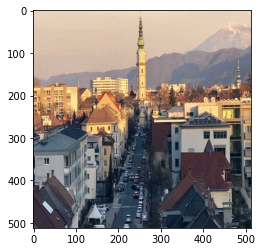

Loss at epoch 0: 40.30830764770508


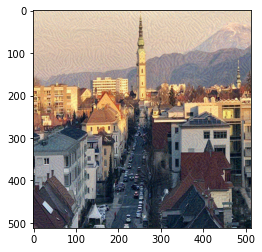

Loss at epoch 10: 2.3010191917419434


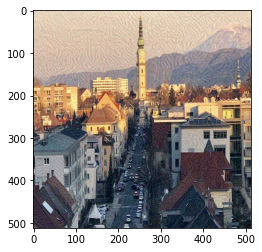

Loss at epoch 20: 1.2030656337738037


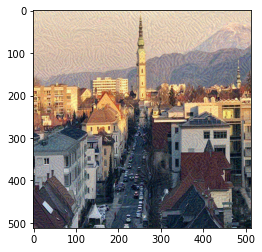

Loss at epoch 30: 1.1138612031936646


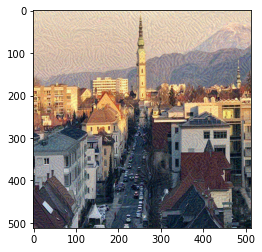

Loss at epoch 40: 1.058574914932251


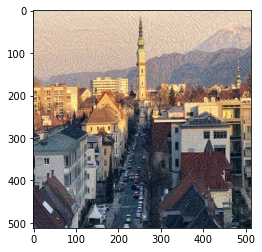

Loss at epoch 50: 1.0188956260681152


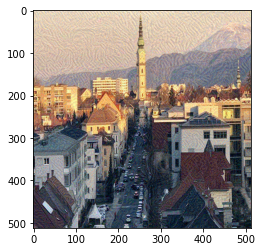

Loss at epoch 60: 0.9889790415763855


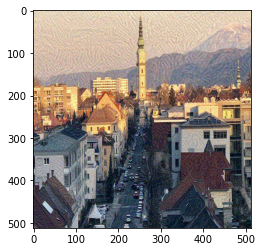

Loss at epoch 70: 0.9578956961631775


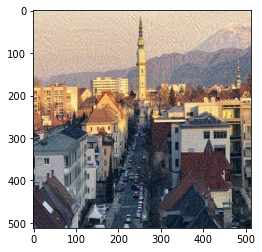

Loss at epoch 80: 1.0700273513793945


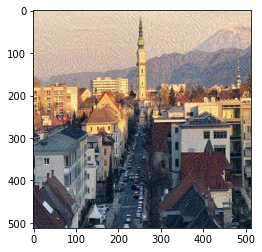

Loss at epoch 90: 1.003962516784668


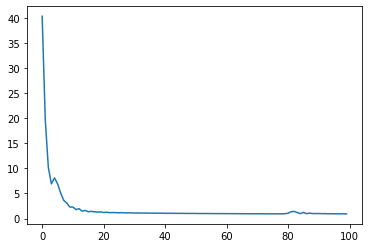

In [11]:
im = torch.tensor(np.array(content_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
im.requires_grad = True

optimizer = torch.optim.Adam([im], lr=10e-3)

losses = [] 
for i in range(100):
    optimizer.zero_grad()  
    loss = style_weight * style_loss(im.clip(0, 1), target_style_features)
    loss += content_weight * content_loss(im.clip(0, 1), target_content_features)
    loss.backward() 
    optimizer.step()
    
    losses.append(loss.item())
    # Showing the progress occasionally
    if i % 10 == 0:
        plt.imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
        plt.show()
        print(f'Loss at epoch {i}: {loss.item()}')

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

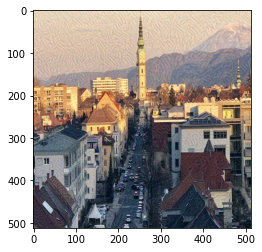

In [10]:
plt.imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
plt.savefig('output.png')